# Trajectory generation

In the second part of the laboratory, we will learn how we can generate trajectories to go from one desired position to another that have nice properties for the control of robots.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.

# Interpolation for trajectory generation
In the last laboratory, we generated desired joint positions from an initial position $\theta_{init}$ at time $t=t_{init}$ to a goal position $\theta_{goal}$ at time $t=t_{end}$ to reach a desired goal with the end-effector.

Indeed, it is generally not a good idea to just send the desired goal joint positions to the PD controller because if they are too far from the actual positions, the error will be large and a large torque will be applied on each motor. This will likely create a very jerky movement which could damage the robot, its motors, etc.

Instead, at every control cycle, it is desirable to compute a desired position to send to the PD controller which is "in-between" the initial and goal position. One straightforward manner to do this is to interpolate between the initial and goal position. For example, we could set
$$\theta_{des}(s) = \theta_{init} + s \cdot (\theta_{goal} - \theta_{init})$$
with $s \in [0,1]$. 
1. When $s=0$ we get $\theta_{des} = \theta_{init}$ (i.e. the joint angle when we started the movement). 
2. When $s=1$, we get $\theta_{des} = \theta_{goal}$ (i.e. the position where we would like to end up). 
3. For any $s$ between 0 and 1, we generate a line segment between those two positions.

This equation allows us to interpolate between $\theta_{init}$ and $\theta_{goal}$. We now need to decide how to choose $s$ to have a nice movement between these values.

# Time parametrization of the trajectory
## Linear time parametrization

Now we would like to change $s$ as a function of time, i.e. find $s(t)$ $\forall t \in [t_{init},\ t_{goal}]$ for a total duration of movement of $T = t_{goal} - t_{init}$. Note that we require $s(t_{init}) = 0$ and $s(t_{goal}) = 1$ (cf. above).

The simplest manner to set $s(t)$ is a linear parametrization, i.e. simply choosing 
$$ s(t) = \frac{t-t_{init}}{t_{goal} - t_{init}} = \frac{t-t_{init}}{T}$$ 

Using the interpolation from above, we find the equation for $\theta(t)$,
$$\theta_{des}(t) = \theta_{init} + \frac{t-t_{init}}{T} (\theta_{goal} - \theta_{init})$$

Doing so implies that the desired velocity and acceleration of the joint will be 
$$\dot{\theta}_{des}(t) = \frac{1}{T} (\theta_{goal} - \theta_{init})$$
and
$$\ddot{\theta}_{des}(t) = 0$$

Therefore, a linear parametrization of time leads to
1. constant desired velocity
2. zero desired acceleration. 

This is potentially problematic because we would instead like to start the motion at rest (velocity at $t=0$ should be 0) and would like to end our movement with 0 velocity (otherwise the robot would not stop).

The figure below show an example of such a trajectory going from position 0 to position 10 in $T=5$ seconds. Notice how the position starts and ends at the desired locations but that the velocity is constant and acceleration is 0.
$$\theta_{des}(t) = \frac{t}{5} \cdot 10$$
$$\dot\theta_{des}(t) = 2$$
$$\ddot\theta_{des}(t) = 0$$
<img src="./lin_interp.png" width="500">

## Time parametrization with velocity constraints
We can instead parametrize $s(t)$ as a polynomial of $t$ such that we can impose further constraints on the desired velociy, acceleration, etc. If we choose $s(t)$ to be an arbitrary function of time, we have 
1. a desired position $\theta_{des}(t) = \theta_{init} + s(t) \cdot (\theta_{goal} - \theta_{init})$,
2. a desired velocity $\dot{\theta}_{des}(t) = \dot{s}(t) \cdot (\theta_{goal} - \theta_{init})$,
3. and a desired acceleration $\ddot{\theta}_{des}(t) = \ddot{s}(t) \cdot (\theta_{goal} - \theta_{init})$

To ensure that the desired velocity at the beginning and the end of the movement is equal to 0, we need to have the following 4 constraints

$$s(t_{init}) = 0$$ 
$$s(t_{goal}) = 1$$
$$\dot{s}(t_{init}) = 0$$
$$\dot{s}(t_{goal}) = 0$$

Because we have 4 constraints, we need to parametrize $s(t)$ with a polynomial of at least degree 3 to have enough open parameters. Lets set 
$$s(t) = a_0 + a_1 (t-t_{init}) + a_2 (t-t_{init})^2 + a_3 (t-t_{init})^3$$

Then we have
$$\dot{s}(t) = a_1 + 2 a_2 (t-t_{init}) + 3 a_3 (t-t_{init})^2$$

The constraint $\dot{s}(t_{init}) = 0$ implies that $a_1 = 0$. Similarly, the constraint that $\dot{s}(t_{goal}) = 0$ imposes that $a_2 = -\frac{3}{2} a_3 T$. 

The constraint $s(t_{init}) = 0$ imposes that $a_0 = 0$. The last constraint, $s(t_{goal}) = 1$ implies that $a_3 = -\frac{2}{T^3}$. 

Putting everything together we find that to impose the 0 velocity constraints at the beginning and at the end of the trajectory, one can choose $$s(t) = \frac{3}{T^2}(t-t_{init})^2 - \frac{2}{T^3}(t-t_{init})^3$$

This results in the following 
1. desired trajectory:
$$\theta_{des}(t) = \theta_{init} + \left(\frac{3}{T^2}(t-t_{init})^2 - \frac{2}{T^3}(t-t_{init})^3\right) \cdot(\theta_{goal} - \theta_{init})$$
2. desired velocity:
$$\dot{\theta}_{des}(t) = \left(\frac{6}{T^2}(t-t_{init}) - \frac{6}{T^3}(t-t_{init})^2\right)\cdot (\theta_{goal} - \theta_{init})$$
3. and desired acceleration
$$\ddot{\theta}_{des}(t) = \left(\frac{6}{T^2} - \frac{12}{T^3}(t-t_{init})\right)\cdot (\theta_{goal} - \theta_{init})$$

The figure below shows the same example as above but with the new parametrization (in orange). Notice how the position still starts and ends at the desired positions and now the velocity starts and ends with 0. The acceleration, however, is non-zero at the beginning and the end.
<img src="./third_interp.png" width="500">

## Time parametrization with acceleration and velocity constraints
In general, if we impose only velocity constraints, we might have non-zero accelerations which can be an issue when generating torques in the PD controller. We generally prefer also imposing acceleration constraints in addition to the other constraints. We then have the following 6 constraints:

$$s(t_{init}) = 0, \ \ s(t_{goal}) = 1$$
$$\dot{s}(t_{init}) = 0, \ \ \dot{s}(t_{goal}) = 0$$
$$\ddot{s}(t_{init}) = 0, \ \ \ddot{s}(t_{goal}) = 0$$

We now need to use a polynomial of at least 5th order to have enough open parameters. Our polynomial is then $$s(t) = a_0 + a_1 (t-t_{init}) + a_2 (t-t_{init})^2 + a_3 (t-t_{init})^3 + a_4 (t-t_{init})^4 + a_5 (t-t_{init})^5$$

As before, we can find the coefficients by solving for the constraints. We find that $a_0 = a_1 = a_2 = 0$, $a_3 = \frac{10}{T^3}$, $a_4 = \frac{-15}{T^4}$ and $a_5 = \frac{6}{T^5}$.
This gives the following 
1. desired position parametrized by time
$$\theta_{des}(t) = \theta_{init} + \left( \frac{10}{T^3} (t-t_{init})^3 + \frac{-15}{T^4} (t-t_{init})^4 + \frac{6}{T^5} (t-t_{init})^5 \right) \cdot (\theta_{goal} - \theta_{init})$$
2. desired velocity
$$\dot{\theta}_{des}(t) = \left( \frac{30}{T^3} (t-t_{init})^2 + \frac{-60}{T^4} (t-t_{init})^3 + \frac{30}{T^5} (t-t_{init})^4 \right) \cdot (\theta_{goal} - \theta_{init})$$
3. and desired acceleration
$$\ddot{\theta}_{des}(t) = \left( \frac{60}{T^3} (t-t_{init}) + \frac{-180}{T^4} (t-t_{init})^2 + \frac{120}{T^5} (t-t_{init})^3 \right)\cdot (\theta_{goal} - \theta_{init})$$

The figure below shows the same example as above but with the new parametrization (in green). Notice how all the start and end constraints are now fullfiled, including starting and endining with 0 velocity and acceleration.
<img src="./fifth_interp.png" width="500">

In [ ]:
# we import useful libraries
import time as t
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from NYUFinger.sim import NYUFingerSimulator  
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

use_real_robot = False

if use_real_robot:
    from NYUFinger.real import NYUFingerHardware
    robot = NYUFingerHardware()
else:
    robot = NYUFingerSimulator()

Exception in thread Thread-6 (sim_loop):
Traceback (most recent call last):
  File "/home/rob2004/miniconda3/envs/rob2004/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/rob2004/miniconda3/envs/rob2004/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/rob2004/miniconda3/envs/rob2004/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rob2004/Desktop/rob2004/Lab/Lab3/NYUFinger/sim.py", line 78, in sim_loop
    self.step()
  File "/home/rob2004/Desktop/rob2004/Lab/Lab3/NYUFinger/sim.py", line 103, in step
    mujoco.mj_step(self.model, self.data)
mujoco.FatalError: mj_makeConstraint: nefc under-allocation: found nefc=2 but allocated only 1


## Question 1: generating trajectories
Write a ``compute_trajectory`` function that takes as input arguments: a starting position, a goal position, a starting time, a final time and the current time t (between starting and final time). The function returns a desired position and a desired velocity. Use a time paramterization such that the velocity and acceleration are 0 at the beginning and end of the movement. You can use the function prototype below.

In [2]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    
    desired_velocity = 0
    T = t_goal - t_init
    t_diff = t - t_init
    desired_position = position_init + (10*(t_diff/T)**3 - 15*(t_diff/T)**4+6*(t_diff/T)**5) * (position_goal-position_init)
    desired_velocity = (30*(t_diff**2)/(T**3) - 60*(t_diff**3)/(T**4) + 30*(t_diff**4)/(T**5)) * (position_goal-position_init)
    # we return the answer
    return desired_position, desired_velocity

## Question 2: generating trajectories to reach desired goals in joint space
Re-use and modify the code and functions from Part I in order to implement the following controller:

1. Use the inverse geometry function to compute joint angles for each of the goal end-effector positions and use the ``compute_trajectory`` function to generate trajectories in joint space to reach all these goals. Use a total time for the movement of T=5 seconds per goal.

2. Use the plotting function below to plot the motion of the foot in space and the joint position/velocity trajectories. Analyze the trajectories of the end-effector.

3. Do the same task but now using a linear time interpolation for the trajectory. Compare these results with the previous ones. Do you see any quantitative or qualitative changes? Which option seems better?

4. Execute the controllers on the real robot, plot the resulting trajectories and analyze the results.

In [3]:
### COPY PASTE YOUR FORWARD KINEMATICS FUNCTION HERE FROM LAB 2 (and other helper functions)
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[:3, 3] = vector
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[1:3, 1:3] = [[cos, -sin], [sin, cos]]
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:3:2,0:3:2] = [[cos, sin], [-sin, cos]]
    
    ### we return the object
    return transform


def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:2,0:2] = [[cos, -sin], [sin, cos]]
    
    ### we return the object
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    ###WRITE YOUR CODE HERE
    SH1=translate([l0, 0,0])@ rotateX(theta[0])
    H1H2= translate([0, 0, l3]) @ rotateZ(theta[1])
    H2K = translate([0, -l1, 0]) @ rotateZ(theta[2])
    KF = translate([0, -l2, 0])
    T_SH1=SH1
    T_SH2 = T_SH1 @ H1H2
    T_SK = T_SH2 @ H2K
    T_SF = T_SK @ KF
    ### we return the object
    return T_SF

In [ ]:
import scipy.optimize


def fingertip_position_error(joint_angles, desired_fingertip_position):
    """
    fingertip_position_error function
    input joint_angles (as a 3D vector) and desired_fingertip_position (as a 3D vector)
    output the squared distance between the desired fingertip position and the one realized by joint_angles
    """
    p_fk = forward_kinematics(joint_angles)[0:3, 3]
    difference = p_fk-desired_fingertip_position
    
    return np.sum(np.power(difference, 2))


def inverse_geometry(desired_fingertip_position):
    """
    inverse geometry function
    input desired_fingertip_position (3D vector of desired position of the fingertip)
    output a vector of joint angles
    """
    # bound = [(0, 2*np.pi),(0, 2*np.pi),(0, 2*np.pi)]
    bound = [(-np.pi, np.pi),(-2*np.pi, 2*np.pi),(-2*np.pi, 2*np.pi)]
    result = scipy.optimize.minimize(fingertip_position_error, 
                                     np.array([0.01, 0.01, 0.01]), 
                                     args=(desired_fingertip_position), 
                                     bounds=bound
                                     )
    bounded_result = result.x
    # bounded_result[1:] = bounded_result[1:] % (2*np.pi)
    return bounded_result

In [31]:
### THE BALL POSITIONS ARE DEFINED HERE ###
# here we create a list of ball positions and display them if we are in simulation
ball_positions = [np.array([0.597,-0.056, 0.0]), np.array([0.521,0.12, 0.0]), np.array([0.3,-0.225, 0.0])]
joint_positions_of_balls = [inverse_geometry(ball_position) for ball_position in ball_positions]

for join_position in joint_positions_of_balls:
    print(np.round(forward_kinematics(join_position), 3)[0:3, 3])

if not use_real_robot:
    for ball in ball_positions:
        robot.add_ball(ball)

[ 0.597 -0.056  0.   ]
[0.521 0.12  0.   ]
[ 0.3   -0.225  0.   ]


In [32]:
def linear_interpolate_trajectory(position_init, position_goal, t_init, t_goal, t):
    desired_position = (t - t_init)/(t_goal-t_init)*(position_goal-position_init) + position_init
    desired_velocity = (position_goal-position_init)/(t_goal-t_init)
    
    # we return the answer
    return desired_position, desired_velocity

In [ ]:
if use_real_robot:
    robot.reset_sensors()

use_linear = True
    
# we simulate for 15 seconds (5 seconds per goal)
run_time = 15.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([10, 10, 10])
D = np.array([0.5, 0.5, 0.5])

## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
time = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_finger_position = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])

# the time to reach a goal
time_to_goal = 5.0

# we use this to know which target we are currently aiming
ball_number = 0

prev_pos, _= robot.get_state()

## this is our main control loop ##
## we do the loop for num_steps ##
t_start = t.time()
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the fingertip using the FK function
    pose = forward_kinematics(q)
    measured_finger_position[i,:] = pose[0:3,3]
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO REACH ALL 3 TARGETS
    # the goal here is to compute q_des and dq_des that the PD controller will follow
    # you will need some internal logic to decide which ball you are currently targetting, etc.
    before = ball_number
    ball_number = int(dt*i//time_to_goal)
    if before != ball_number:
        prev_pos, _= robot.get_state()
    
    ### WRITE YOUR CODE HERE ###
    # change this according to your needs so the robot moves according to your goals
    if not use_linear:
        q_des, dq_des = compute_trajectory(
            prev_pos, 
            joint_positions_of_balls[ball_number], 
            time_to_goal*ball_number, 
            time_to_goal*(ball_number+1)-dt, 
            dt*i)
    else:
        q_des, dq_des = linear_interpolate_trajectory(
            prev_pos, 
            joint_positions_of_balls[ball_number], 
            time_to_goal*ball_number, 
            time_to_goal*(ball_number+1)-dt, 
            dt*i)
    # if (dt*(i+1)%time_to_goal ==0 ):
    #     print(ball_number)
    #     print("Time: ", dt*i)
    #     print(joint_positions_of_balls[ball_number])
    #     print("Ball position:", ball_positions[ball_number])
    #     print("Desired position", forward_kinematics(q_des)[0:3, 3])
    desired_finger_position[i, :] = forward_kinematics(q_des)[0:3, 3]

    # if np.any(np.abs(dq_des) > 100):
    #     print("Large dq_des")
    #     print(prev_pos)
    #     print(joint_positions_of_balls[ball_number])
    #     print(time_to_goal*ball_number)
    #     print(time_to_goal*(ball_number+1)-dt)
    #     print(dt*i)
    
    # we save the desired positions/velocities for later plotting 
    desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    ##PD controller
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    if not use_real_robot:
        robot.step()
    t.sleep(max(sleep_time:=dt*(i+1) - (t.time()-t_start), 0))

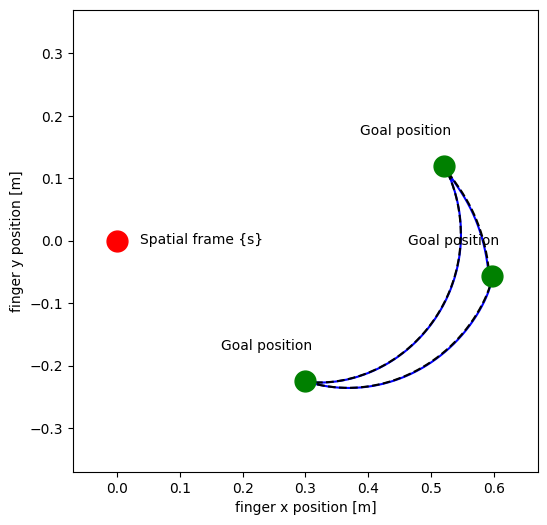

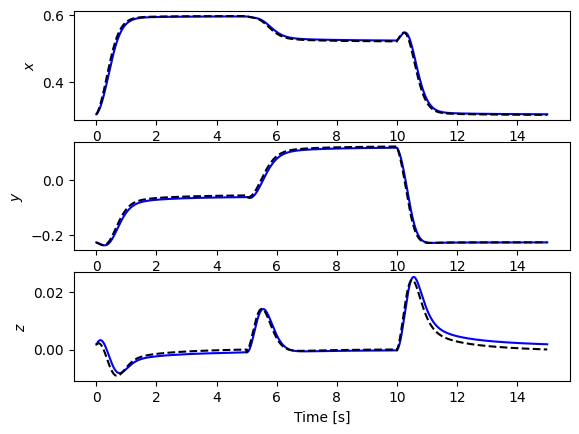

In [35]:
def plot_finger_trajectory(finger_position, desired_finger_position, ball_positions):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.plot(desired_finger_position[:,0],desired_finger_position[:,1], '--k')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    
    fig = plt.figure()
    
    plt.subplot(3,1,1)
    plt.plot(time, measured_finger_position[:,0], 'b-', time, desired_finger_position[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,1,2)
    plt.plot(time, measured_finger_position[:,1], 'b-', time, desired_finger_position[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,1,3)
    plt.plot(time, measured_finger_position[:,2], 'b-', time, desired_finger_position[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')

plot_finger_trajectory(measured_finger_position, desired_finger_position, ball_positions)

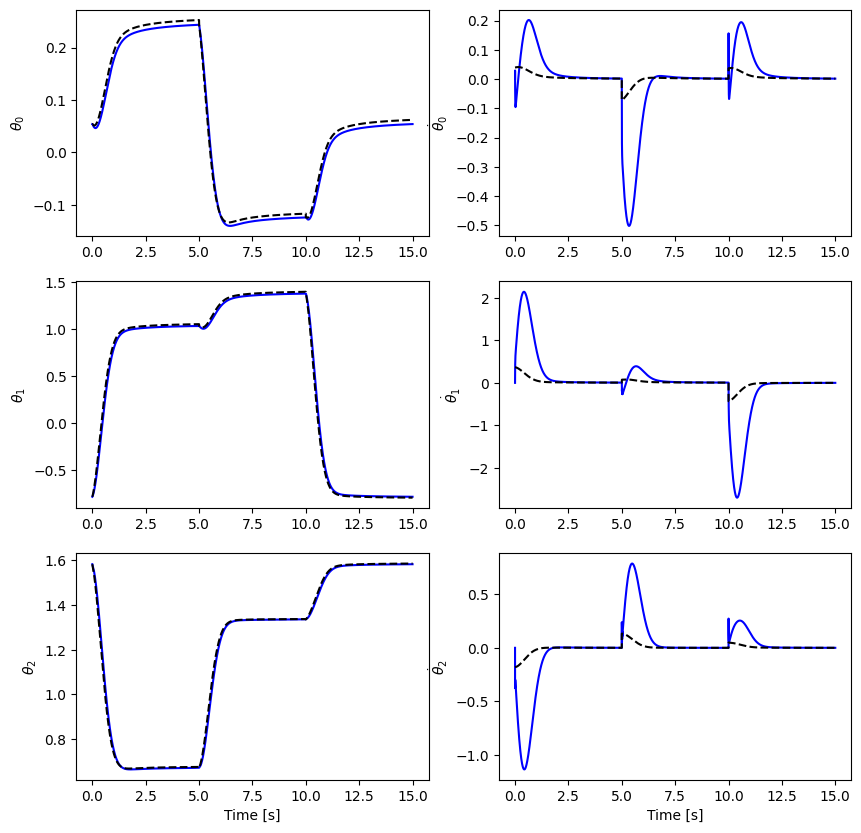

In [36]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)

## [Optional] Question 3: generating arbitrary finger trajectories
1. Write a controller that can move the fingertip of the robot in a circle in the vertical plane leveraging the inverse geometry function.
2. Test the controller in simulation and on the real robot. Provide plots of the results.